# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [20]:
# Don’t worry about this. This is needed to interpret the Python code that is embedded in the data set. You only need it literally in the very next code cell and nowhere else. 
from ast import literal_eval

# The rest is just the stuff from the lecture.
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [21]:
rules_data_path = 'data/rules.tsv.xz'                       # You do not need to decompress this yourself. Pandas understands how to read compressed data.

df_rules = pd.read_csv(rules_data_path,
                       sep='\t',
                       quoting=3,                           # This disables interpretation of quotes by Pandas itself, because both single and double quotes will be resolved by literal_eval.
                       converters={
                           'consequent_item': literal_eval,
                           'antecedent_items': literal_eval # This reads something like ["Grandma's 8\" Chip Cookies", '6" Apple Pie'] into a list, so you will get a column where each individual cell is a list.
                       },
                       low_memory=True)                     # For Chris

<unknown>:1: SyntaxWarning: invalid escape sequence '\G'


But just *how* many rules were just loaded‽

In [22]:
# Show the list of column names and the number of rules.
print(df_rules.columns, len(df_rules))

Index(['consequent_item', 'transaction_count', 'item_set_count',
       'antecedent_count', 'consequent_count', 'antecedent_items'],
      dtype='object') 1048575


In [23]:
df_rules.head()

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items
0,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
1,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr..."
2,Total 0% with Honey Nonfat Greek Strained Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
3,Total 0% Raspberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
4,Pineapple Yogurt 2%,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr..."


## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [28]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.

df_rules['support'] =  df_rules['item_set_count'] / df_rules['transaction_count']
df_rules['confidence'] = df_rules['item_set_count'] / df_rules['antecedent_count']
df_rules['lift'] = df_rules['confidence'] / (df_rules['consequent_count']/df_rules['transaction_count'])
print(df_rules.head(50))

                                      consequent_item  transaction_count  \
0   Total 2% with Raspberry Pomegranate Lowfat Gre...            3346083   
1   Total 2% Lowfat Greek Strained Yogurt With Blu...            3346083   
2    Total 0% with Honey Nonfat Greek Strained Yogurt            3346083   
3                           Total 0% Raspberry Yogurt            3346083   
4                                 Pineapple Yogurt 2%            3346083   
5                          Fat Free Strawberry Yogurt            3346083   
6                           Fat Free Blueberry Yogurt            3346083   
7   Total 2% with Raspberry Pomegranate Lowfat Gre...            3346083   
8   Total 2% Lowfat Greek Strained Yogurt With Blu...            3346083   
9   Total 2% Greek Strained Yogurt with Cherry 5.3 oz            3346083   
10  Total 2% All Natural Greek Strained Yogurt wit...            3346083   
11                          Total 0% Raspberry Yogurt            3346083   
12          

The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

*I think yogurts as daily consumptions, the supermarkets will put them in shelves where are easy to reach out *

In [37]:
# Query the rule set if you have to to find out more.
top_lift_rules = df_rules.sort_values(by='lift', ascending=False).head(10)
print("Top 10 Rules by Lift:")
print(top_lift_rules[['antecedent_items', 'consequent_item', 'lift']])



Top 10 Rules by Lift:
                                     antecedent_items  \
1   [Fat Free Strawberry Yogurt, Total 0% Raspberr...   
4   [Fat Free Strawberry Yogurt, Total 0% Raspberr...   
6   [Fat Free Strawberry Yogurt, Total 0% Raspberr...   
5   [Fat Free Blueberry Yogurt, Pineapple Yogurt 2...   
0   [Fat Free Blueberry Yogurt, Pineapple Yogurt 2...   
3   [Fat Free Blueberry Yogurt, Pineapple Yogurt 2...   
2   [Fat Free Blueberry Yogurt, Pineapple Yogurt 2...   
9   [Pineapple Yogurt 2%, Total 0% Raspberry Yogur...   
10  [Pineapple Yogurt 2%, Total 0% Raspberry Yogur...   
13  [Pineapple Yogurt 2%, Total 0% Raspberry Yogur...   

                                      consequent_item          lift  
1   Total 2% Lowfat Greek Strained Yogurt With Blu...  21465.598514  
4                                 Pineapple Yogurt 2%  21465.598514  
6                           Fat Free Blueberry Yogurt  21465.598514  
5                          Fat Free Strawberry Yogurt  21465.598514  


## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [46]:
#  Filter for exactly 1 antecedent item and create a copy
rules_with_one_antecedent = df_rules[df_rules['antecedent_items'].apply(lambda x: len(x) == 1)].copy()

# Further filter for lift between 5 and 20
rules_with_high_lift = rules_with_one_antecedent[(rules_with_one_antecedent['lift'] >= 5) & (rules_with_one_antecedent['lift'] <= 20)]

# Create masks for 'Hummus' in either antecedent or consequent
mask_hummus_antecedent = rules_with_high_lift['antecedent_items'].apply(lambda x: 'Hummus' in x[0])
mask_hummus_consequent = rules_with_high_lift['consequent_item'].str.contains('Hummus')

# Keep rules where either antecedent or consequent contains 'Hummus', but not both
hummus_rules = rules_with_high_lift[
    (mask_hummus_antecedent & ~mask_hummus_consequent) | 
    (~mask_hummus_antecedent & mask_hummus_consequent)
].copy()

# Convert antecedent_items to string type since there is only one antecedent
hummus_rules['antecedent_item'] = hummus_rules['antecedent_items'].apply(lambda x: str(x[0]))

# Replace any item containing 'Hummus' in the consequent with just 'Hummus'
hummus_rules['consequent_item'] = hummus_rules['consequent_item'].str.replace(r'Hummus.*', 'Hummus', regex=True)

# Assign the subset to df_rules_subset
df_rules_subset = hummus_rules.reset_index(drop=True)

# Display the final subset of rules
print("Filtered Rules Subset:")
print(df_rules_subset[['antecedent_item', 'consequent_item', 'support', 'confidence', 'lift']])


Filtered Rules Subset:
                                      antecedent_item  \
0                Roasted Red Pepper Hummus With Chips   
1                              Organic Classic Hummus   
2                            Organic White Pita Bread   
3                            Organic Whole Wheat Pita   
4                         Mini Whole Wheat Pita Bread   
5                                 Sea Salt Pita Chips   
6                              Organic Classic Hummus   
7                   Lentil Chips, Himalayan Pink Salt   
8                        Garbanzo Beans No Salt Added   
9                   Organic Whole Peeled Baby Carrots   
10                        Baba Ghannouge Eggplant Dip   
11  Sonoma Organic Wraps Multigrain Tortillas With...   
12                            Pita Chips Simply Naked   
13                            Honey Whole Wheat Bread   
14                                         White Pita   
15                                Organic Wraps Wheat   
16      

Build a network `graph_rules_subset` from the association rules subset.

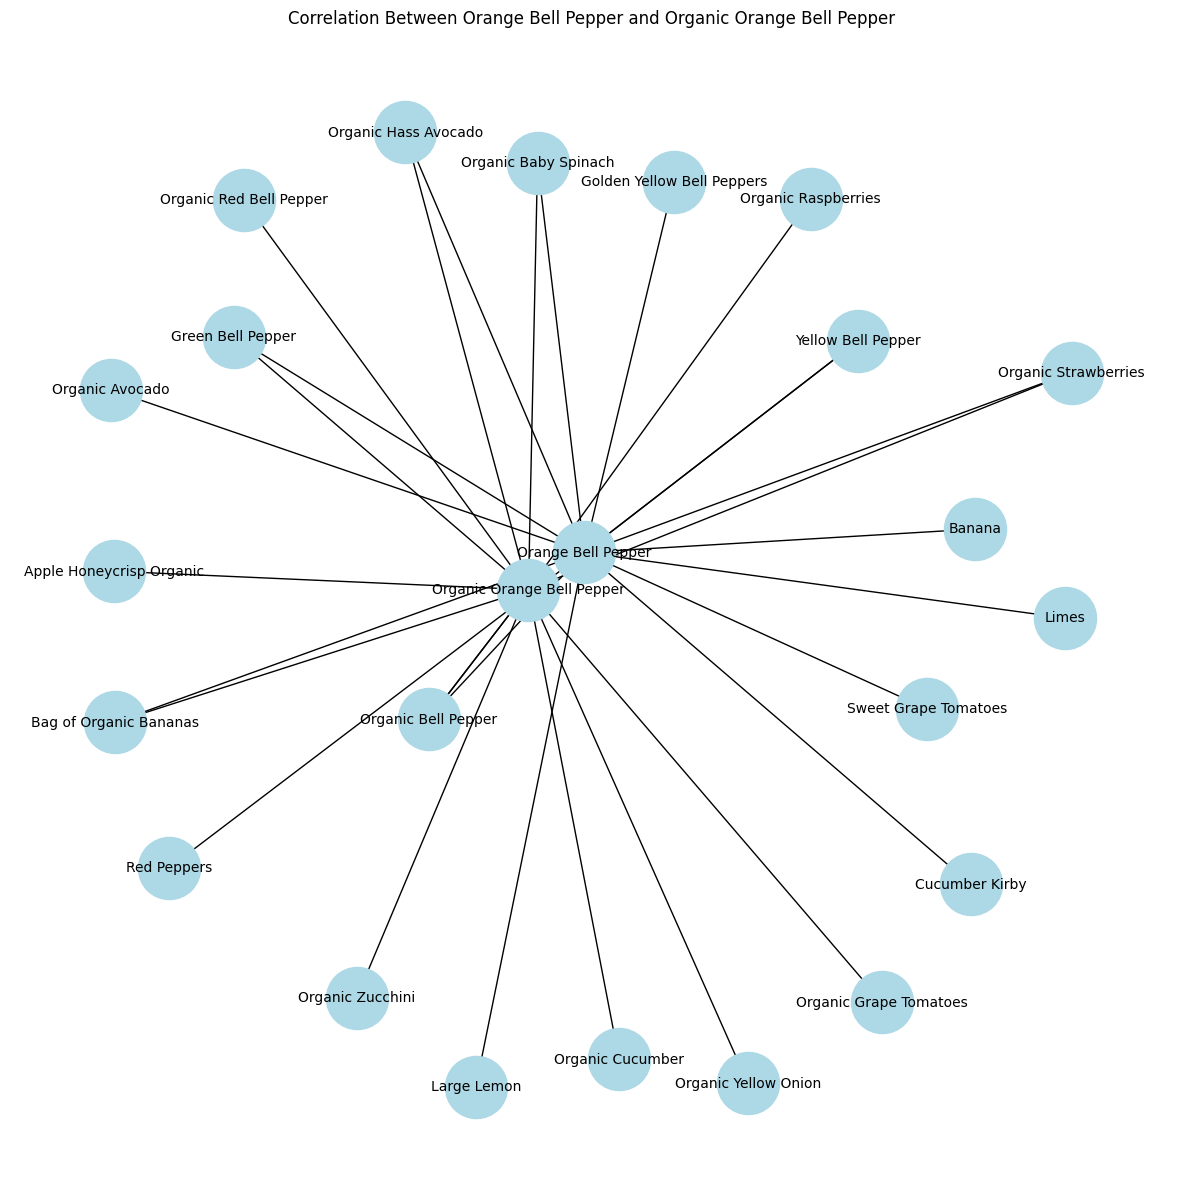

In [58]:
# Define graph_rules_subset, add the graph’s edges, and plot it. You may need a large figure size, smaller node size, and smaller font size.

df_rules_subset = df_rules[
    (df_rules['antecedent_items'].apply(lambda x: 'Orange Bell Pepper' in x or 'Organic Orange Bell Pepper' in x) |
     df_rules['consequent_item'].apply(lambda x: 'Orange Bell Pepper' in x or 'Organic Orange Bell Pepper' in x))
]

df_rules_subset = df_rules_subset[df_rules_subset['antecedent_items'].apply(lambda x: len(x) == 1)]
df_rules_subset.loc[:, 'antecedent_items'] = df_rules_subset['antecedent_items'].apply(lambda x: x[0])

graph_rules_subset = nx.MultiDiGraph()

edges = list(zip(df_rules_subset['antecedent_items'], df_rules_subset['consequent_item']))
graph_rules_subset.add_edges_from(edges)

plt.figure(figsize=(15, 15))  
pos = nx.spring_layout(graph_rules_subset, seed=42, k=1)  

nx.draw_networkx_nodes(graph_rules_subset, pos, node_size=2000, node_color='lightblue')
nx.draw_networkx_edges(graph_rules_subset, pos, arrows=True)
nx.draw_networkx_labels(graph_rules_subset, pos, font_size=10)

plt.title("Correlation Between Orange Bell Pepper and Organic Orange Bell Pepper")
plt.axis('off')
plt.show()





What can you tell about people who buy hummus?

*(Write your answer here.)*

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [60]:

# Define the basket items
basket_items = ['Orange Bell Pepper', 'Organic Red Bell Pepper']

filtered_rules = df_rules[
    (df_rules['antecedent_items'].apply(lambda x: any(item in x for item in basket_items)) |
     df_rules['antecedent_items'].apply(lambda x: len(x) == 1 and x[0] in basket_items))
]

predictions = filtered_rules[['consequent_item', 'lift']]


predictions = predictions.drop_duplicates().sort_values(by='lift', ascending=False)


top_20_predictions = predictions.head(20)


print("Top 20 Predicted Items to Add to the Basket:")
print(top_20_predictions)

Top 20 Predicted Items to Add to the Basket:
                                          consequent_item       lift
342462      Icelandic Style Skyr Blueberry Non-fat Yogurt  80.202217
345882      Icelandic Style Skyr Blueberry Non-fat Yogurt  71.145298
346832           Nonfat Icelandic Style Strawberry Yogurt  68.820769
346901                           Non Fat Raspberry Yogurt  68.651858
349532      Icelandic Style Skyr Blueberry Non-fat Yogurt  62.434341
350852      Icelandic Style Skyr Blueberry Non-fat Yogurt  59.433078
350991                           Non Fat Raspberry Yogurt  59.077960
351360      Icelandic Style Skyr Blueberry Non-fat Yogurt  58.178302
351433           Nonfat Icelandic Style Strawberry Yogurt  57.946047
351881      Icelandic Style Skyr Blueberry Non-fat Yogurt  56.871965
352283                         Vanilla Skyr Nonfat Yogurt  55.893163
352884                        Organic Frozen Mango Chunks  54.484612
353323                         Vanilla Skyr Nonfat Yogurt 

## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.

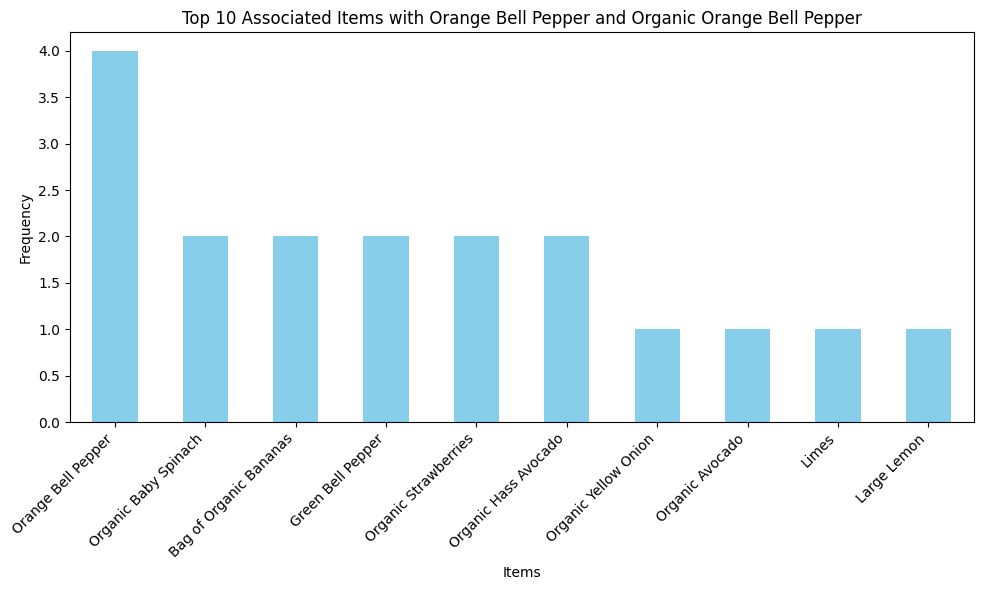

In [59]:

df_rules_subset = df_rules[
    (df_rules['antecedent_items'].apply(lambda x: 'Orange Bell Pepper' in x or 'Organic Orange Bell Pepper' in x) |
     df_rules['consequent_item'].apply(lambda x: 'Orange Bell Pepper' in x or 'Organic Orange Bell Pepper' in x))
]

df_rules_subset = df_rules_subset[df_rules_subset['antecedent_items'].apply(lambda x: len(x) == 1)]
df_rules_subset['antecedent_item'] = df_rules_subset['antecedent_items'].apply(lambda x: x[0])

associated_counts = df_rules_subset['consequent_item'].value_counts()


top_associated = associated_counts.head(10)


plt.figure(figsize=(10, 6))
top_associated.plot(kind='bar', color='skyblue')
plt.title('Top 10 Associated Items with Orange Bell Pepper and Organic Orange Bell Pepper')
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  
plt.show()
